# Modeling

`20_230517_sliced_filt_patient_stmary.npy`를 이용해서 ResNet 모델을 학습시킨다. 보다 좀 더 독자적인 모델로 발전시키는 것도 좋을 것 같다.

**1. Normalization**
- 불러온 PLETH 데이터 각각에 대해서 `min-max` 정규화를 실행한다.

**2. Model Configuration**
- `Dataset split`: train(80%):validation(20%) 5-Fold CV
- `Testset`: BIDMC dataset
- `Batch size`: [4, 16, 32, 64, 128, 256] 
- `Epochs`: 100
- `Callbacks`: [Earlystopping, ModelCheckpoint]
- `Optimizer`: Adam
- `Loss function`: [MAE, MSE, RMSE]

In [1]:
import gzip
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = '/root/Workspace/DataWarehouse/stMary_RRpo'

In [2]:
with gzip.open(f'{DATA_PATH}/21_230518_resamp_sliced125_filt_patient_stmary.pickle.gzip', 'rb') as f:
    dataset = pickle.load(f)

# with gzip.open(f'{DATA_PATH}/20_230518_sliced125_filt_volunteer_stmary.pickle.gzip', 'rb') as f:
#     volunteer = pickle.load(f)

# print(len(patient), len(volunteer))

# dataset = []
# dataset.extend(patient)
# dataset.extend(volunteer)
# len(dataset) 

In [3]:
len(dataset), len(dataset[0][0])

(6508, 1800)

In [4]:
random.seed(42)
random.shuffle(dataset)

In [5]:
pleths = []
resps = []
for ppg, rr in dataset:
    pleths.append(ppg.astype(np.float64))
    resps.append(rr)

pleths = np.asarray(pleths)
resps = np.asarray(resps)
print(pleths.shape, resps.shape)

(6508, 1800) (6508,)


## 1. Normalization

In [6]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler = MinMaxScaler()
scaled_pleths = np.asarray([scaler.fit_transform(pleth.reshape(-1,1)) for pleth in pleths])
print(scaled_pleths.shape, type(scaled_pleths[0][0][0]))

(6508, 1800, 1) <class 'numpy.float64'>


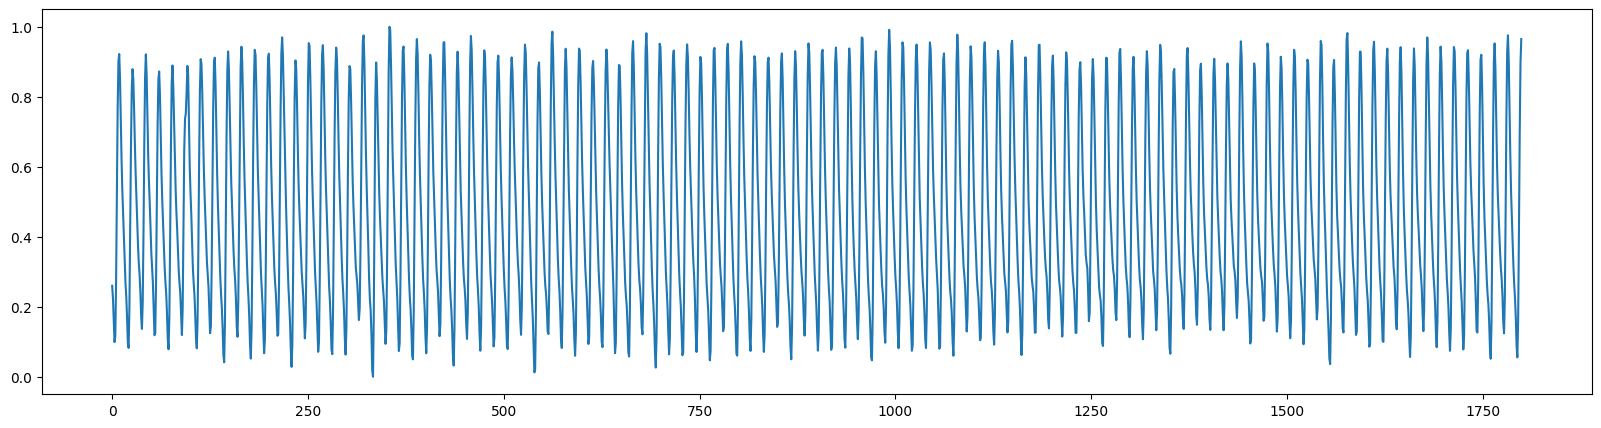

In [8]:
plt.figure(figsize=(20,5))
plt.plot(scaled_pleths[5])
plt.show()

In [9]:
ratio_tr = 0.8
train_x, train_y = scaled_pleths[:int(len(scaled_pleths)*ratio_tr)], resps[:int(len(resps)*ratio_tr)]
val_x, val_y = scaled_pleths[int(len(scaled_pleths)*ratio_tr):], resps[int(len(resps)*ratio_tr):]
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(5206, 1800, 1) (5206,)
(1302, 1800, 1) (1302,)


## Model Architecture: ResNet

In [10]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv1D, Add, LeakyReLU, MaxPooling1D, Flatten, Dense, BatchNormalization, Activation
print(f'Is GPU Avaliable: {tf.config.list_physical_devices("GPU")}')

2023-05-25 10:54:43.793151: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 10:54:43.832391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 10:54:44.522407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
class ResnetIdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size, strides):
        super(ResnetIdentityBlock, self).__init__(name='resnet_block')
        self.conv1a = Conv1D(filters, kernel_size=kernel_size, strides=strides, padding='same')
        self.bn1a = BatchNormalization()

        self.conv1b = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same')
        self.bn1b = BatchNormalization()

        self.conv1c = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same')
        self.bn1c = BatchNormalization()

    
    def call(self, input, training=False):
        x0 = self.conv1a(input)
        x0 = self.bn1a(x0, training=training)
        x0 = Activation('relu')(x0)

        x1 = self.conv1b(x0)
        x1 = self.bn1b(x1, training=training)
        x1 = Activation('relu')(x1)
        x1 = self.conv1c(x1)
        x1 = self.bn1c(x1, training=training)
        x1 = Activation('relu')(x1)

        x = Add()([x0 + x1])
        return Activation('relu')(x)

In [12]:
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet_block = [ResnetIdentityBlock(6*(2**i), 3, 2) for i in range(5)]
        self.max1d = MaxPooling1D(strides=2, padding='same')
        self.flatten = Flatten()
        self.d20 = Dense(20, activation='relu')
        self.d10 = Dense(10, activation='relu')
        self.d1 = Dense(1)

    
    def call(self, inputs, training=None, mask=None):
        x = inputs
        for i in range(5):
            x = self.resnet_block[i](x, training=training)

        x = self.max1d(x)
        x = self.flatten(x)
        x = self.d20(x)
        x = self.d10(x)
        return self.d1(x)
    

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}
    

    def test_step(self, data):
        x, y = data

        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

In [17]:
EPOCHS = 100
BATCH_SIZE = [4, 16, 32, 64, 128, 256]
LR = [0.001, 0.0001]
kf = KFold(n_splits=5)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    # ModelCheckpoint('../models/230525-BianResnet', monitor='val_loss', save_best_only=True)
]

In [ ]:
experiment = {}
for lr in LR:
    for bs in BATCH_SIZE:
        print('==='*100)
        print(f'BATCH SIZE: {bs}, Learning rate: {lr}')
        train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(bs)
        val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(bs)

        model = ResNet()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss=keras.losses.MeanAbsoluteError(),
            metrics=keras.metrics.MeanAbsoluteError()
        )

        history = model.fit(
                train_dataset,
                epochs=EPOCHS,
                callbacks=callbacks,
                validation_data=val_dataset
            )
        
        experiment[f'exp_{bs}B_{lr}LR'] = min(history.history['val_loss'])

BATCH SIZE: 4, Learning rate: 0.001


2023-05-18 14:49:24.831786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14432 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


Epoch 1/100


2023-05-18 14:49:25.713134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]
2023-05-18 14:49:31.719709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-05-18 14:49:32.515328: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x560a11f918b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-18 14:49:32.515394: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-05-18 14:49:32.529564: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-18 14:

1302/1302 [==============================] - ETA: 0s - loss: 4.0891 - mean_absolute_error: 4.0891

2023-05-18 14:50:22.741633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


1302/1302 [==============================] - 60s 35ms/step - loss: 4.0891 - mean_absolute_error: 4.0891 - val_loss: 3.6049 - val_mean_absolute_error: 3.6049
Epoch 2/100
1302/1302 [==============================] - 44s 34ms/step - loss: 2.7769 - mean_absolute_error: 2.7769 - val_loss: 3.1835 - val_mean_absolute_error: 3.1835
Epoch 3/100
1302/1302 [==============================] - 44s 34ms/step - loss: 2.0413 - mean_absolute_error: 2.0413 - val_loss: 2.8356 - val_mean_absolute_error: 2.8356
Epoch 4/100
1302/1302 [==============================] - 44s 34ms/step - loss: 1.6863 - mean_absolute_error: 1.6863 - val_loss: 2.2048 - val_mean_absolute_error: 2.2048
Epoch 5/100
1302/1302 [==============================] - 45s 35ms/step - loss: 1.5427 - mean_absolute_error: 1.5427 - val_loss: 1.7839 - val_mean_absolute_error: 1.7839
Epoch 6/100
1302/1302 [==============================] - 45s 34ms/step - loss: 1.3348 - mean_absolute_error: 1.3348 - val_loss: 1.3570 - val_mean_absolute_error: 1.357

2023-05-18 15:04:27.401386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


326/326 [==============================] - ETA: 0s - loss: 3.1269 - mean_absolute_error: 3.1269

2023-05-18 15:04:49.532650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


326/326 [==============================] - 23s 38ms/step - loss: 3.1269 - mean_absolute_error: 3.1269 - val_loss: 4.9589 - val_mean_absolute_error: 4.9589
Epoch 2/100
326/326 [==============================] - 11s 34ms/step - loss: 1.9772 - mean_absolute_error: 1.9772 - val_loss: 1.6790 - val_mean_absolute_error: 1.6790
Epoch 3/100
326/326 [==============================] - 11s 35ms/step - loss: 1.6837 - mean_absolute_error: 1.6837 - val_loss: 1.9765 - val_mean_absolute_error: 1.9765
Epoch 4/100
326/326 [==============================] - 11s 34ms/step - loss: 1.5402 - mean_absolute_error: 1.5402 - val_loss: 1.9412 - val_mean_absolute_error: 1.9412
Epoch 5/100
326/326 [==============================] - 11s 32ms/step - loss: 1.4448 - mean_absolute_error: 1.4448 - val_loss: 1.6902 - val_mean_absolute_error: 1.6902
Epoch 6/100
326/326 [==============================] - 11s 34ms/step - loss: 1.3103 - mean_absolute_error: 1.3103 - val_loss: 1.1993 - val_mean_absolute_error: 1.1993
Epoch 7/10

2023-05-18 15:08:55.941053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


163/163 [==============================] - ETA: 0s - loss: 3.4021 - mean_absolute_error: 3.4021

2023-05-18 15:09:13.137445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


163/163 [==============================] - 18s 42ms/step - loss: 3.4021 - mean_absolute_error: 3.4021 - val_loss: 4.8487 - val_mean_absolute_error: 4.8487
Epoch 2/100
163/163 [==============================] - 6s 36ms/step - loss: 2.3110 - mean_absolute_error: 2.3110 - val_loss: 4.7201 - val_mean_absolute_error: 4.7201
Epoch 3/100
163/163 [==============================] - 6s 37ms/step - loss: 1.8810 - mean_absolute_error: 1.8810 - val_loss: 4.5522 - val_mean_absolute_error: 4.5522
Epoch 4/100
163/163 [==============================] - 6s 35ms/step - loss: 1.6952 - mean_absolute_error: 1.6952 - val_loss: 4.4637 - val_mean_absolute_error: 4.4637
Epoch 5/100
163/163 [==============================] - 6s 36ms/step - loss: 1.5800 - mean_absolute_error: 1.5800 - val_loss: 4.2127 - val_mean_absolute_error: 4.2127
Epoch 6/100
163/163 [==============================] - 6s 36ms/step - loss: 1.4660 - mean_absolute_error: 1.4660 - val_loss: 3.5820 - val_mean_absolute_error: 3.5820
Epoch 7/100
163

2023-05-18 15:11:23.128322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


81/82 [============================>.] - ETA: 0s - loss: 4.9784 - mean_absolute_error: 4.9784

2023-05-18 15:11:37.663671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


82/82 [==============================] - 15s 45ms/step - loss: 4.9702 - mean_absolute_error: 4.9702 - val_loss: 6.3958 - val_mean_absolute_error: 6.3958
Epoch 2/100
82/82 [==============================] - 3s 39ms/step - loss: 2.3172 - mean_absolute_error: 2.3172 - val_loss: 7.1573 - val_mean_absolute_error: 7.1573
Epoch 3/100
82/82 [==============================] - 3s 39ms/step - loss: 1.6950 - mean_absolute_error: 1.6950 - val_loss: 4.7469 - val_mean_absolute_error: 4.7469
Epoch 4/100
82/82 [==============================] - 3s 38ms/step - loss: 1.4704 - mean_absolute_error: 1.4704 - val_loss: 4.6920 - val_mean_absolute_error: 4.6920
Epoch 5/100
82/82 [==============================] - 3s 37ms/step - loss: 1.2969 - mean_absolute_error: 1.2969 - val_loss: 4.5510 - val_mean_absolute_error: 4.5510
Epoch 6/100
82/82 [==============================] - 3s 39ms/step - loss: 1.2420 - mean_absolute_error: 1.2420 - val_loss: 4.4215 - val_mean_absolute_error: 4.4215
Epoch 7/100
82/82 [========

2023-05-18 15:12:49.575553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


41/41 [==============================] - ETA: 0s - loss: 4.9961 - mean_absolute_error: 4.9961

2023-05-18 15:13:02.408652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


41/41 [==============================] - 13s 69ms/step - loss: 4.9961 - mean_absolute_error: 4.9961 - val_loss: 14.1525 - val_mean_absolute_error: 14.1525
Epoch 2/100
41/41 [==============================] - 2s 52ms/step - loss: 2.1196 - mean_absolute_error: 2.1196 - val_loss: 12.9615 - val_mean_absolute_error: 12.9615
Epoch 3/100
41/41 [==============================] - 2s 52ms/step - loss: 1.8292 - mean_absolute_error: 1.8292 - val_loss: 13.1553 - val_mean_absolute_error: 13.1553
Epoch 4/100
41/41 [==============================] - 2s 51ms/step - loss: 1.4842 - mean_absolute_error: 1.4842 - val_loss: 12.6293 - val_mean_absolute_error: 12.6293
Epoch 5/100
41/41 [==============================] - 2s 52ms/step - loss: 1.4135 - mean_absolute_error: 1.4135 - val_loss: 10.8827 - val_mean_absolute_error: 10.8827
Epoch 6/100
41/41 [==============================] - 2s 52ms/step - loss: 1.2667 - mean_absolute_error: 1.2667 - val_loss: 9.1421 - val_mean_absolute_error: 9.1421
Epoch 7/100
41/41

2023-05-18 15:14:12.133237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


20/21 [===========================>..] - ETA: 0s - loss: 5.3954 - mean_absolute_error: 5.3954

2023-05-18 15:14:25.124632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


21/21 [==============================] - 14s 110ms/step - loss: 5.3570 - mean_absolute_error: 5.3570 - val_loss: 16.7302 - val_mean_absolute_error: 16.7302
Epoch 2/100
21/21 [==============================] - 2s 89ms/step - loss: 2.3998 - mean_absolute_error: 2.3998 - val_loss: 16.2916 - val_mean_absolute_error: 16.2916
Epoch 3/100
21/21 [==============================] - 2s 88ms/step - loss: 1.8462 - mean_absolute_error: 1.8462 - val_loss: 16.0505 - val_mean_absolute_error: 16.0505
Epoch 4/100
21/21 [==============================] - 2s 89ms/step - loss: 1.5601 - mean_absolute_error: 1.5601 - val_loss: 15.6692 - val_mean_absolute_error: 15.6692
Epoch 5/100
21/21 [==============================] - 2s 89ms/step - loss: 1.5527 - mean_absolute_error: 1.5527 - val_loss: 15.4073 - val_mean_absolute_error: 15.4073
Epoch 6/100
21/21 [==============================] - 2s 89ms/step - loss: 1.3170 - mean_absolute_error: 1.3170 - val_loss: 13.8760 - val_mean_absolute_error: 13.8760
Epoch 7/100
21

2023-05-18 15:15:22.903175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


1302/1302 [==============================] - ETA: 0s - loss: 4.2989 - mean_absolute_error: 4.2989

2023-05-18 15:16:15.745656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


1302/1302 [==============================] - 56s 35ms/step - loss: 4.2989 - mean_absolute_error: 4.2989 - val_loss: 3.6453 - val_mean_absolute_error: 3.6453
Epoch 2/100
1302/1302 [==============================] - 45s 35ms/step - loss: 3.2446 - mean_absolute_error: 3.2446 - val_loss: 2.7780 - val_mean_absolute_error: 2.7780
Epoch 3/100
1302/1302 [==============================] - 45s 34ms/step - loss: 2.6098 - mean_absolute_error: 2.6098 - val_loss: 3.9351 - val_mean_absolute_error: 3.9351
Epoch 4/100
1302/1302 [==============================] - 45s 34ms/step - loss: 2.3505 - mean_absolute_error: 2.3505 - val_loss: 3.6043 - val_mean_absolute_error: 3.6043
Epoch 5/100
1302/1302 [==============================] - 45s 34ms/step - loss: 2.1056 - mean_absolute_error: 2.1056 - val_loss: 2.8130 - val_mean_absolute_error: 2.8130
Epoch 6/100
1302/1302 [==============================] - 45s 35ms/step - loss: 1.9942 - mean_absolute_error: 1.9942 - val_loss: 3.5203 - val_mean_absolute_error: 3.520

2023-05-18 15:44:33.854608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


325/326 [============================>.] - ETA: 0s - loss: 4.0611 - mean_absolute_error: 4.0611

2023-05-18 15:44:55.447362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


326/326 [==============================] - 23s 36ms/step - loss: 4.0588 - mean_absolute_error: 4.0588 - val_loss: 10.7048 - val_mean_absolute_error: 10.7048
Epoch 2/100
326/326 [==============================] - 11s 35ms/step - loss: 2.6126 - mean_absolute_error: 2.6126 - val_loss: 5.0399 - val_mean_absolute_error: 5.0399
Epoch 3/100
326/326 [==============================] - 11s 35ms/step - loss: 2.0368 - mean_absolute_error: 2.0368 - val_loss: 2.1895 - val_mean_absolute_error: 2.1895
Epoch 4/100
326/326 [==============================] - 11s 35ms/step - loss: 1.8009 - mean_absolute_error: 1.8009 - val_loss: 1.6235 - val_mean_absolute_error: 1.6235
Epoch 5/100
326/326 [==============================] - 11s 34ms/step - loss: 1.5689 - mean_absolute_error: 1.5689 - val_loss: 2.0186 - val_mean_absolute_error: 2.0186
Epoch 6/100
326/326 [==============================] - 11s 33ms/step - loss: 1.4240 - mean_absolute_error: 1.4240 - val_loss: 2.5423 - val_mean_absolute_error: 2.5423
Epoch 7/

2023-05-18 15:49:41.416379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


163/163 [==============================] - ETA: 0s - loss: 4.3993 - mean_absolute_error: 4.3993

2023-05-18 15:49:56.739031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


163/163 [==============================] - 16s 36ms/step - loss: 4.3993 - mean_absolute_error: 4.3993 - val_loss: 6.7692 - val_mean_absolute_error: 6.7692
Epoch 2/100
163/163 [==============================] - 6s 34ms/step - loss: 3.0879 - mean_absolute_error: 3.0879 - val_loss: 4.5937 - val_mean_absolute_error: 4.5937
Epoch 3/100
163/163 [==============================] - 6s 35ms/step - loss: 2.3709 - mean_absolute_error: 2.3709 - val_loss: 4.5960 - val_mean_absolute_error: 4.5960
Epoch 4/100
163/163 [==============================] - 6s 35ms/step - loss: 2.0970 - mean_absolute_error: 2.0970 - val_loss: 2.9750 - val_mean_absolute_error: 2.9750
Epoch 5/100
163/163 [==============================] - 6s 36ms/step - loss: 1.8544 - mean_absolute_error: 1.8544 - val_loss: 2.2677 - val_mean_absolute_error: 2.2677
Epoch 6/100
163/163 [==============================] - 6s 37ms/step - loss: 1.5933 - mean_absolute_error: 1.5933 - val_loss: 2.4557 - val_mean_absolute_error: 2.4557
Epoch 7/100
163

2023-05-18 15:51:53.812748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


81/82 [============================>.] - ETA: 0s - loss: 6.2719 - mean_absolute_error: 6.2719

2023-05-18 15:52:07.884563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


82/82 [==============================] - 15s 46ms/step - loss: 6.2569 - mean_absolute_error: 6.2569 - val_loss: 13.4763 - val_mean_absolute_error: 13.4763
Epoch 2/100
82/82 [==============================] - 3s 40ms/step - loss: 3.2823 - mean_absolute_error: 3.2823 - val_loss: 9.6684 - val_mean_absolute_error: 9.6684
Epoch 3/100
82/82 [==============================] - 3s 40ms/step - loss: 2.6682 - mean_absolute_error: 2.6682 - val_loss: 5.8532 - val_mean_absolute_error: 5.8532
Epoch 4/100
82/82 [==============================] - 3s 39ms/step - loss: 2.0801 - mean_absolute_error: 2.0801 - val_loss: 7.4225 - val_mean_absolute_error: 7.4225
Epoch 5/100
82/82 [==============================] - 3s 40ms/step - loss: 1.7648 - mean_absolute_error: 1.7648 - val_loss: 10.2663 - val_mean_absolute_error: 10.2663
Epoch 6/100
82/82 [==============================] - 3s 39ms/step - loss: 1.6106 - mean_absolute_error: 1.6106 - val_loss: 9.5559 - val_mean_absolute_error: 9.5559
Epoch 7/100
82/82 [====

2023-05-18 15:55:04.430922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


40/41 [============================>.] - ETA: 0s - loss: 6.1758 - mean_absolute_error: 6.1758

2023-05-18 15:55:16.632177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


41/41 [==============================] - 13s 62ms/step - loss: 6.1448 - mean_absolute_error: 6.1448 - val_loss: 15.5093 - val_mean_absolute_error: 15.5093
Epoch 2/100
41/41 [==============================] - 2s 52ms/step - loss: 4.0363 - mean_absolute_error: 4.0363 - val_loss: 13.0764 - val_mean_absolute_error: 13.0764
Epoch 3/100
41/41 [==============================] - 2s 52ms/step - loss: 3.5935 - mean_absolute_error: 3.5935 - val_loss: 10.6164 - val_mean_absolute_error: 10.6164
Epoch 4/100
41/41 [==============================] - 2s 52ms/step - loss: 3.1912 - mean_absolute_error: 3.1912 - val_loss: 7.5724 - val_mean_absolute_error: 7.5724
Epoch 5/100
41/41 [==============================] - 2s 52ms/step - loss: 2.8125 - mean_absolute_error: 2.8125 - val_loss: 5.0710 - val_mean_absolute_error: 5.0710
Epoch 6/100
41/41 [==============================] - 2s 51ms/step - loss: 2.4229 - mean_absolute_error: 2.4229 - val_loss: 6.0111 - val_mean_absolute_error: 6.0111
Epoch 7/100
41/41 [==

2023-05-18 15:55:47.630392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


20/21 [===========================>..] - ETA: 0s - loss: 7.1215 - mean_absolute_error: 7.1215

2023-05-18 15:56:00.462474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


21/21 [==============================] - 13s 113ms/step - loss: 7.0863 - mean_absolute_error: 7.0863 - val_loss: 16.7790 - val_mean_absolute_error: 16.7790
Epoch 2/100
21/21 [==============================] - 2s 88ms/step - loss: 4.2737 - mean_absolute_error: 4.2737 - val_loss: 15.4661 - val_mean_absolute_error: 15.4661
Epoch 3/100
21/21 [==============================] - 2s 89ms/step - loss: 3.8484 - mean_absolute_error: 3.8484 - val_loss: 14.0028 - val_mean_absolute_error: 14.0028
Epoch 4/100
21/21 [==============================] - 2s 89ms/step - loss: 3.4960 - mean_absolute_error: 3.4960 - val_loss: 12.0121 - val_mean_absolute_error: 12.0121
Epoch 5/100
21/21 [==============================] - 2s 89ms/step - loss: 3.2007 - mean_absolute_error: 3.2007 - val_loss: 9.6848 - val_mean_absolute_error: 9.6848
Epoch 6/100
21/21 [==============================] - 2s 90ms/step - loss: 2.9118 - mean_absolute_error: 2.9118 - val_loss: 6.8207 - val_mean_absolute_error: 6.8207
Epoch 7/100
21/21 

In [ ]:
experiment1 = experiment
experiment1

{'exp_4B_0.001LR': 1.2351291179656982,
 'exp_16B_0.001LR': 1.0833022594451904,
 'exp_32B_0.001LR': 1.2183526754379272,
 'exp_64B_0.001LR': 2.0885744094848633,
 'exp_128B_0.001LR': 1.1050900220870972,
 'exp_256B_0.001LR': 4.395741939544678,
 'exp_4B_0.0001LR': 1.51192307472229,
 'exp_16B_0.0001LR': 1.2315237522125244,
 'exp_32B_0.0001LR': 1.513879656791687,
 'exp_64B_0.0001LR': 0.9552336931228638,
 'exp_128B_0.0001LR': 5.070973873138428,
 'exp_256B_0.0001LR': 4.662842750549316}

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(256)
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(256)

model = ResNet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=keras.metrics.MeanAbsoluteError()
)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=val_dataset
)

Epoch 1/100


2023-05-19 17:09:00.295463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5206]
	 [[{{node Placeholder/_1}}]]


21/21 [==============================] - ETA: 0s - loss: 12.8953 - mean_absolute_error: 12.8953

2023-05-19 17:09:12.084452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1302]
	 [[{{node Placeholder/_1}}]]


21/21 [==============================] - 12s 58ms/step - loss: 12.8953 - mean_absolute_error: 12.8953 - val_loss: 16.8197 - val_mean_absolute_error: 16.8197 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 1s 39ms/step - loss: 3.8998 - mean_absolute_error: 3.8998 - val_loss: 13.6993 - val_mean_absolute_error: 13.6993 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 1s 38ms/step - loss: 2.3234 - mean_absolute_error: 2.3234 - val_loss: 11.7505 - val_mean_absolute_error: 11.7505 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 1s 40ms/step - loss: 1.5783 - mean_absolute_error: 1.5783 - val_loss: 11.9008 - val_mean_absolute_error: 11.9008 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 1s 43ms/step - loss: 1.2980 - mean_absolute_error: 1.2980 - val_loss: 11.3692 - val_mean_absolute_error: 11.3692 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 1s 42ms/step - loss: 1.1410 - mean_absolute_error: 1.1410 - v

In [17]:
min(history.history['val_loss'])

0.7684762477874756